In [1]:
# Imports (for the framework)
import torch
import math
# Imports (for plotting)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#switching off autograd globally
torch.set_grad_enabled(False)

# 1. Modules

## Baseclass

In [3]:
class Module(object):

    """
    Base class for all modules.
    """

    def forward(self, input_):
        """
        Function to get the input, apply forward pass of module and
        returns a tensor or a tuple of tensors.
        """
        raise NotImplementedError

    def backward(self, gradswrtoutput):
        """
        Function to get the input gradient of the loss with respect to the
        module’s output, accumulate the gradient wrt the parameters, and
        return a tensor or a tuple of tensors containing the gradient of
        the loss wrt the module’s input.
        """
        raise NotImplementedError

    def param(self):
        """
        Returns a list of pairs, each composed of a parameter tensor, and
        a gradient tensor of same size.
        """
        return []

    def zero_grad(self):
        """
        Sets the gradients of a module to 0
        """
        return []

## Activation Functions

### TanH

In [4]:
class TanH(Module):

    """Module to apply the Hyperbolic Tangent function"""

    def __init__(self):

        super().__init__()
        self.name = "TanH"

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying tanh to the input

        Parameters:
            input (Tensor): The tensor on which the tanh should be applied

        Returns:
            Tensor: The tensor obtained after applying the tanh on the input
        """

        self.out_ = input_.tanh()

        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying tanh

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """

        return gradwrtoutput * (1 - self.out_.pow(2))

    def param(self):

        return []

### ReLU

In [5]:
class ReLU(Module):

    """Module to apply the Rectified Linear function"""

    def __init__(self):

        super().__init__()
        self.name = "ReLU"

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying ReLU to the input.

        Parameters:
            input (Tensor): The tensor on which the ReLU should be applied

        Returns:
            Tensor: The tensor obtained after applying the ReLU on the input
        """

        self.out = input_.clamp(min=0.0)

        return self.out

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying ReLU

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """

        self.out[self.out <= 0] = 0
        self.out[self.out > 0] = 1

        return gradwrtoutput * self.out

    def param(self):

        return []

### Sigmoid

In [6]:
class Sigmoid(Module):

    """Module to apply the Sigmoid function"""

    def __init__(self):

        super().__init__()
        self.name = "Sigmoid"

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying sigmoid to the input.

        Parameters:
            input (Tensor): The tensor on which the sigmoid should be applied

        Returns:
            Tensor: The tensor obtained after applying the sigmoid on the input
        """

        self.out_ = input_.sigmoid()

        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying sigmoid

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """

        return gradwrtoutput * (self.out_ - self.out_**2)

    def param(self):

        return []

## Batch Norm

## Losses

### MSE

In [7]:
class MSELoss(Module):

    """Module to calculate the Mean Squared Error."""

    def __init__(self):
        super().__init__()
        self.name = "MSE Loss"

    def __str__(self):
        return self.name

    def forward(self, output_: torch.Tensor,
                target: torch.Tensor) -> torch.Tensor:
        """Returns the MSE Loss between output_ and target

        Parameters:
            output_ (Tensor): First tensor to calculate the MSE.
            target (Tensor): Second tensor to calculate the MSE.

        Returns:
            Tensor: The Mean Squared Loss between input_ and target
        """

        self.error = output_ - target
        self.loss = self.error.pow(2).mean()

        return self.loss

    def backward(self) -> torch.Tensor:
        """
        gradient of loss

        Returns:
            Tensor: The gradient of Mean Squared Loss between input_ and target
        """

        return (2 * self.error)/self.error.size()[0]

## Optimizer

In [8]:
class Optimizer(object):

    """
    Base class for optimizers.
    """

    def step(self):
        """
         Perform the single optimization step
        """

        raise NotImplementedError

### SGD

In [9]:
class SGD(Optimizer):

    """
    Module to perform Stochastic Gradient Descent
    """

    def __init__(self, params: list, lr=0.01):
        """
        Parameters:
            params (list): List of the parameters of the network
            lr (float): The learning rate of the network
        """

        super().__init__()
        self.name = "SGD"

        self.params = params
        self.lr = lr

        if self.lr <= 0.0:
            raise ValueError(
                "Learning rate {} should be greater than zero".format(self.lr))

    def __str__(self):
        return self.name

    def step(self):
        """
        Function to perform the single optimization step
        """

        for weight, gradient in self.params:
            if (weight is None) or (gradient is None):
                # incase of activation function modules, skip them
                continue
            else:
                weight.add_(-self.lr*gradient)

## Layers

### Linear 

In [10]:
class Linear(Module):

    """
    Module that implements a linear matrix operation layer
    """

    def __init__(self, in_features: int, out_features: int,
                 bias: bool = True, weightsinit: str = "uniform"):
        """
        Initialises the layer by creating empty weight and bias tensors
        and initialising them using uniform distribution.

        Parameters:
            in_features (int): The size of each input sample
            out_features (int): The size of each output sample
            bias – If set to False, the layer will not learn an additive bias. Default: True
            weightsinit (str): The type of weight initialization to use
        """

        super().__init__()
        self.name = "Linear"

        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weightsinit = weightsinit

        self.w = torch.empty(self.in_features, self.out_features)
        self.gradw = torch.empty(self.in_features, self.out_features)

        if self.bias:
            self.b = torch.empty(self.out_features)
            self.gradb = torch.empty(self.out_features)
        else:
            self.b = None
            self.gradb = None

        self.initWeights()

    def __str__(self):
        return self.name

    def initWeights(self):
        """
        Initialises the weight and bias parameters of the layer depending on
        the weightinit parameter. Irrespective of the weightinit parameter
        the bias are always zero initialised 

        If "weightsinit" is
            1. uniform (by default), the weights are initiliased using uniform distribution.
            2. xavier, the weights are initiliased using Xavier Initialisation.
            3. kaiming, the weights are initiliased using Kaiming Initialisation when using ReLU layer
        """

        if self.weightsinit == "uniform":
            k=math.sqrt(1.0/self.in_features)
            self.w.uniform_(-k,k)

        elif self.weightsinit == "xavier":
            self.w.normal_(0,math.sqrt(2/(self.in_features + self.out_features)))

        elif self.weightsinit == "kaiming":
            self.w.normal_(0,math.sqrt(2/(self.in_features)))

        self.gradw.fill_(0)
        
        if self.b is not None:
            self.b.fill_(0)
            self.gradb.fill_(0)

                                       
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """
        Computes the forward pass of the layer by multiplying the input with weights and adding the bias
        """

        self.inp = input_

        if self.b is None:
            self.output = self.inp.matmul(self.w)
        else:
            self.output = self.inp.matmul(self.w).add(self.b)

        return self.output

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Computes the gradient for the weights and biases.
        """

        gradw = self.inp.t().matmul(gradwrtoutput)
        self.gradw.add_(gradw)

        if self.b is not None:
            gradb = gradwrtoutput.sum(0)
            self.gradb.add_(gradb)
        gradient = gradwrtoutput.matmul(self.w.t())

        return gradient

    def param(self) -> list:
        """
        Returns the parameters of the layer
        """

        params = [(self.w, self.gradw)]
        if self.b is not None:
            params.append((self.b, self.gradb))

        return params

    def zero_grad(self):
        """
        Sets the gradient to zero
        """

        self.gradw.zero_()

        if self.b is not None:
            self.gradb.zero_()

### Sequential

In [11]:
class Sequential(Module):
    """
    Module to hold the layers and build the Network
    """

    def __init__(self, *args):
        """
        Parameters:
            *args (list[Module]): The list of modules to be constructed in the
            network.
        """
        super().__init__()
        self.name = "Sequential"

        # A list to hold all layers of the network
        self.modules = [module for module in args]

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """
        Feed Forward prediction of the network. The input is propagated through
        all the layers and the output of the final layer is returned.

        Parameters:
            input_ (Tensor): The input sample
        """
        self.inp = input_
        # incase of no layers, the input itself is returned as output
        output = input_

        for module in self.modules:
            output = module.forward(output)

        self.output = output

        return self.output

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Backward propagation of the network. The error is propagated through
        all the layers iteratively.

        Parameters:
            input_ (Tensor): The input sample
        """
        # The error is propagated in the reverse (backward) direction
        for module in reversed(self.modules):
            gradwrtoutput = module.backward(gradwrtoutput)

    def param(self) -> list:
        """
        List of parameters of all modules

        Returns:
            params (list): List of tuple of weight and bias of each layer in
            the network
        """

        params = []
        for module in self.modules:
            params.extend(module.param())

        return params

    def zero_grad(self):
        """
        Sets the gradient to zero of all modules
        """

        for weight, gradient in self.param():
            if (weight is None) or (gradient is None):
                # incase of activation function modules, skip them
                continue
            else:
                gradient.zero_()

# 2. Data generation

In [12]:
def generate_data(num_points: int) -> [torch.Tensor, torch.Tensor]:
    """
    Function to generate the dataset of 1,000 points sampled uniformly
    in [0, 1]^2, each with a label 0 if outside the disk centered at (0.5; 0.5)
    of radius 1/sqrt(2*pi), and 1 inside.

    Parameters:
        num_points (int): The number of points to be generated

    Returns:
        Tensor : A two dimensional input data with points sampled between [0,1]
        Tensor : A two dimensional output data that contains labels
        corresponding to the input data generated above as one hot encoded variable
    """

    input_ = torch.Tensor(num_points, 2).uniform_(0, 1)

    labels = input_.sub(0.5).pow(2).sum(1).sub(1 / (2 * math.pi)).sign().add(1).div(2).long()

    labels_onehot = torch.empty(num_points, 2).fill_(0)
    labels_onehot[:, 0] = labels == 0
    labels_onehot[:, 1] = labels == 1

    return input_, labels_onehot

# 3. Train Model

In [13]:
def train_model(model: Sequential, train_input: torch.Tensor,
                train_target: torch.Tensor, loss_criteria: Module,
                learning_rate: float, mini_batch_size: int, nb_epochs: int
                ) -> list:
    """
    Function to train a model and return the epoch wise loss as a list.

    Parameters:
        model (Sequential): The neural network model
        train_input (Tensor): The input data samples
        train_target (Tensor): The target of data samples
        loss_criteria (Module): The loss function to use to train the model
        learning_rate (float): The learning rate to be update the weights of
        the model
        mini_batch_size (int): The batch size to train the model
        nb_epochs (int): The number of eppochs to train the network

    Returns:
        losses : A list of loss collected after each epoch of training
    """

    optimizer = SGD(model.param(), lr=learning_rate)
    losses = []
    for epoch_number in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            loss_ = loss_criteria.forward(
                output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            model.backward(loss_criteria.backward())
            optimizer.step()
        if epoch_number % 100 == 0:
            print("\tEpoch {} Training loss {}".format(
                epoch_number, loss_.item()))
        losses.append(loss_.item())
    return losses


def compute_nb_errors(model: Sequential, input_: torch.Tensor,
                      target: torch.Tensor) -> int:
    """
    Computes and returns the number of misclassifications done by the model

    Parameters:
        model (Sequential): The neural network model
        input_ (Tensor): The input data samples
        target (Tensor): The target of data samples

    Returns:
        nb_data_errors (int): The number of misclassifications.

    """

    nb_data_errors = 0

    output = model.forward(input_)

    _, predicted = torch.max(output.data, 1)

    _, actual = torch.max(target.data, 1)

    for k in range(input_.size()[0]):
        if actual.data[k] != predicted[k]:
            nb_data_errors = nb_data_errors + 1
    return nb_data_errors

# 4. Experiments

## Data Generation and Normalization

In [14]:
# generate the training and test samples

train_input, train_target = generate_data(1000)
test_input, test_target = generate_data(1000)

# normalising the train and test data
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
# avoid printing the result
print()

## Models

We define the models to experiment with various parameters. All models will have an input layer, an output layer and 3 hidden layers with 25 neurons each. The factors that can be used for experiments are: The type of activation, the type of loss, the type of weight initialisation and whether or not to use batch normalisation.

| **Model Number** | **Activation** | **Loss**      | **Weight Initialisation** |
|:----------------:|:--------------:|:-------------:|:-------------------------:|
| 1                | TanH           | MSE           | Uniform                   |
| 2                | TanH           | MSE           | Xavier                    |
| 3                | ReLU           | MSE           | Uniform                   |
| 4                | ReLU           | MSE           | kaiming                   |

In [15]:
Model_1 = Sequential(Linear(2, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 2), Sigmoid())

Model_2 = Sequential(Linear(2, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 2, weightsinit="xavier"), Sigmoid())


Model_3 = Sequential(Linear(2, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 2), Sigmoid())

Model_4 = Sequential(Linear(2, 25, weightsinit="kaiming"), ReLU(),
                     Linear(25, 25, weightsinit="kaiming"), ReLU(),
                     Linear(25, 25, weightsinit="kaiming"), ReLU(),
                     Linear(25, 25, weightsinit="kaiming"), ReLU(),
                     Linear(25, 2, weightsinit="kaiming"), Sigmoid())

In [16]:
mseloss = MSELoss()

In [17]:
models = {
          1: {"model": Model_1, "activation": "TanH", "loss": mseloss,
              "weightint": "Uniform"},
          2: {"model": Model_2, "activation": "TanH", "loss": mseloss,
              "weightint": "Xavier"},
          3: {"model": Model_3, "activation": "ReLU", "loss": mseloss,
              "weightint": "Uniform"},
          4: {"model": Model_4, "activation": "ReLU", "loss": mseloss,
              "weightint": "kaiming"}
}

In [18]:
learning_rate = 0.01
nb_epochs = 1000
model_result_attributes = {}
mini_batch_size = 100

for id_num, M in models.items():
    print("Model {} with {} activation, with {} weight initialisation ".format(id_num, M["activation"], M["weightint"], str(M["loss"])))

    model = M["model"]

    model_loss = train_model(model, train_input, train_target, M["loss"],
                             learning_rate, mini_batch_size, nb_epochs)

    nb_train_errors = compute_nb_errors(model, train_input, train_target)
    nb_test_errors = compute_nb_errors(model, test_input, test_target)

    train_accuracy = (100 * (
        train_input.size(0)-nb_train_errors)) / train_input.size(0)

    test_accuracy = (100 * (
        test_input.size(0) - nb_test_errors)) / test_input.size(0)

    train_error = 100 - train_accuracy
    test_error = 100 - test_accuracy

    model_result_attributes[id_num] = {"epoch_loss": model_loss,
                                       "train_accuracy": train_accuracy,
                                       "train_error": test_accuracy,
                                       "test_accuracy": train_error,
                                       "test_error": test_error}

    print(
        '\nTrain Accuracy {:0.2f}% {:d}/{:d}'.format(
            train_accuracy, (train_input.size(0) - nb_train_errors),
            train_input.size(0)))

    print(
        'Test Accuracy {:0.2f}% {:d}/{:d}'.format(
            test_accuracy, (test_input.size(0) - nb_test_errors),
            test_input.size(0)))

    print(
        'Train Error {:0.2f}% {:d}/{:d}'.format(
            train_error, nb_train_errors, train_input.size(0)))

    print('Test Error {:0.2f}% {:d}/{:d}'.format(
        test_error, nb_test_errors, test_input.size(0)))

    print("\n")

Model 1 with TanH activation, with Uniform weight initialisation 
	Epoch 0 Training loss 0.24961894750595093
	Epoch 100 Training loss 0.24751147627830505
	Epoch 200 Training loss 0.24604088068008423
	Epoch 300 Training loss 0.24449986219406128
	Epoch 400 Training loss 0.24246159195899963
	Epoch 500 Training loss 0.23931129276752472
	Epoch 600 Training loss 0.23370182514190674
	Epoch 700 Training loss 0.22124315798282623
	Epoch 800 Training loss 0.18143653869628906
	Epoch 900 Training loss 0.08908256888389587

Train Accuracy 98.00% 980/1000
Test Accuracy 98.20% 982/1000
Train Error 2.00% 20/1000
Test Error 1.80% 18/1000


Model 2 with TanH activation, with Xavier weight initialisation 
	Epoch 0 Training loss 0.2623366415500641
	Epoch 100 Training loss 0.22695928812026978
	Epoch 200 Training loss 0.1349714994430542
	Epoch 300 Training loss 0.06160420551896095
	Epoch 400 Training loss 0.03711550310254097
	Epoch 500 Training loss 0.026482388377189636
	Epoch 600 Training loss 0.021021755412

# 4. Plotting Loss

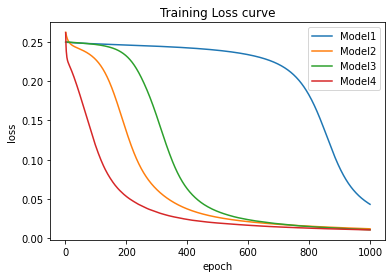

In [19]:
epochs = range(1, nb_epochs+1)

for mnum, mattr in model_result_attributes.items():
    plt.plot(epochs, mattr["epoch_loss"], label="Model" + str(mnum))

plt.title("Training Loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [20]:
learning_rate = 0.01
nb_epochs = 1000
mini_batch_size = 100

model_loss_plots={1:[],2:[],3:[],4:[]}
model_accuracies_train_plots={1:[],2:[],3:[],4:[]}
model_accuracies_test_plots={1:[],2:[],3:[],4:[]}
model_error_train_plots={1:[],2:[],3:[],4:[]}
model_error_test_plots={1:[],2:[],3:[],4:[]}

for iters in range(10):
        losses=[]
        accuracies=[]

        model = Sequential(Linear(2, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 2), Sigmoid())


        model_loss = train_model(model, train_input, train_target, mseloss,
                                 learning_rate, mini_batch_size, nb_epochs)

        nb_train_errors = compute_nb_errors(model, train_input, train_target)
        nb_test_errors = compute_nb_errors(model, test_input, test_target)

        train_accuracy = (100 * (
            train_input.size(0)-nb_train_errors)) / train_input.size(0)

        test_accuracy = (100 * (
            test_input.size(0) - nb_test_errors)) / test_input.size(0)


        model_loss_plots[1].append(model_loss)
        model_accuracies_train_plots[1].append(train_accuracy)
        model_accuracies_test_plots[1].append(test_accuracy)
        model_error_train_plots[1].append(100-train_accuracy)
        model_error_test_plots[1].append(100-test_accuracy)



for iters in range(10):
        losses=[]
        accuracies=[]

        model = Sequential(Linear(2, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 2, weightsinit="xavier"), Sigmoid())


        model_loss = train_model(model, train_input, train_target, mseloss,
                                 learning_rate, mini_batch_size, nb_epochs)

        nb_train_errors = compute_nb_errors(model, train_input, train_target)
        nb_test_errors = compute_nb_errors(model, test_input, test_target)

        train_accuracy = (100 * (
            train_input.size(0)-nb_train_errors)) / train_input.size(0)

        test_accuracy = (100 * (
            test_input.size(0) - nb_test_errors)) / test_input.size(0)


        model_loss_plots[2].append(model_loss)
        model_accuracies_train_plots[2].append(train_accuracy)
        model_accuracies_test_plots[2].append(test_accuracy)
        model_error_train_plots[2].append(100-train_accuracy)
        model_error_test_plots[2].append(100-test_accuracy)



for iters in range(10):
        losses=[]
        accuracies=[]

        model = Sequential(Linear(2, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 2), Sigmoid())


        model_loss = train_model(model, train_input, train_target, mseloss,
                                 learning_rate, mini_batch_size, nb_epochs)

        nb_train_errors = compute_nb_errors(model, train_input, train_target)
        nb_test_errors = compute_nb_errors(model, test_input, test_target)

        train_accuracy = (100 * (
            train_input.size(0)-nb_train_errors)) / train_input.size(0)

        test_accuracy = (100 * (
            test_input.size(0) - nb_test_errors)) / test_input.size(0)


        model_loss_plots[3].append(model_loss)
        model_accuracies_train_plots[3].append(train_accuracy)
        model_accuracies_test_plots[3].append(test_accuracy)
        model_error_train_plots[3].append(100-train_accuracy)
        model_error_test_plots[3].append(100-test_accuracy)


for iters in range(10):
        losses=[]
        accuracies=[]

        model = Sequential(Linear(2, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 2, weightsinit="kaiming"), Sigmoid())

        model_loss = train_model(model, train_input, train_target, mseloss,
                                 learning_rate, mini_batch_size, nb_epochs)

        nb_train_errors = compute_nb_errors(model, train_input, train_target)
        nb_test_errors = compute_nb_errors(model, test_input, test_target)

        train_accuracy = (100 * (
            train_input.size(0)-nb_train_errors)) / train_input.size(0)

        test_accuracy = (100 * (
            test_input.size(0) - nb_test_errors)) / test_input.size(0)


        model_loss_plots[4].append(model_loss)
        model_accuracies_train_plots[4].append(train_accuracy)
        model_accuracies_test_plots[4].append(test_accuracy)
        model_error_train_plots[4].append(100-train_accuracy)
        model_error_test_plots[4].append(100-test_accuracy)

	Epoch 0 Training loss 0.2520046830177307
	Epoch 100 Training loss 0.24938251078128815
	Epoch 200 Training loss 0.2480127513408661
	Epoch 300 Training loss 0.2467874139547348
	Epoch 400 Training loss 0.24543137848377228
	Epoch 500 Training loss 0.2437582015991211
	Epoch 600 Training loss 0.24147792160511017
	Epoch 700 Training loss 0.23794053494930267
	Epoch 800 Training loss 0.23104186356067657
	Epoch 900 Training loss 0.2088652402162552
	Epoch 0 Training loss 0.24989204108715057
	Epoch 100 Training loss 0.24800758063793182
	Epoch 200 Training loss 0.24669040739536285
	Epoch 300 Training loss 0.2453346699476242
	Epoch 400 Training loss 0.24364878237247467
	Epoch 500 Training loss 0.24125057458877563
	Epoch 600 Training loss 0.237442284822464
	Epoch 700 Training loss 0.23051363229751587
	Epoch 800 Training loss 0.2136460840702057
	Epoch 900 Training loss 0.16368545591831207
	Epoch 0 Training loss 0.25079113245010376
	Epoch 100 Training loss 0.24930177628993988
	Epoch 200 Training loss 

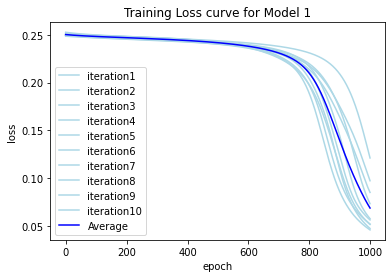

In [21]:
vals=model_loss_plots[1]
c=1
for loss in vals:
    epochs=range(len(loss))
    plt.plot(epochs, loss, 'lightblue',label="iteration" + str(c))
    c+=1


a = np.array(vals)

res = np.average(a, axis=0)
plt.plot(epochs, res, 'blue',label="Average")
    
plt.title("Training Loss curve for Model 1")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

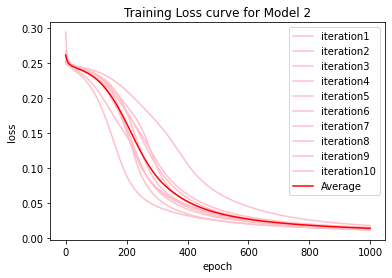

In [22]:
vals=model_loss_plots[2]
c=1
for loss in vals:
    epochs=range(len(loss))
    plt.plot(epochs, loss, 'pink',label="iteration" + str(c))
    c+=1


a = np.array(vals)

res = np.average(a, axis=0)
plt.plot(epochs, res, 'red',label="Average")
    
plt.title("Training Loss curve for Model 2")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

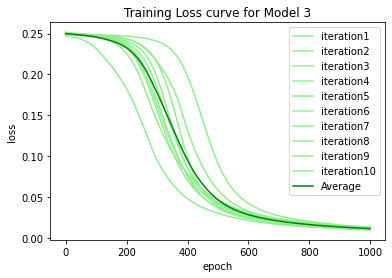

In [23]:
vals=model_loss_plots[3]
c=1
for loss in vals:
    epochs=range(len(loss))
    plt.plot(epochs, loss, 'lightgreen',label="iteration" + str(c))
    c+=1


a = np.array(vals)

res = np.average(a, axis=0)
plt.plot(epochs, res, 'green',label="Average")
    
plt.title("Training Loss curve for Model 3")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

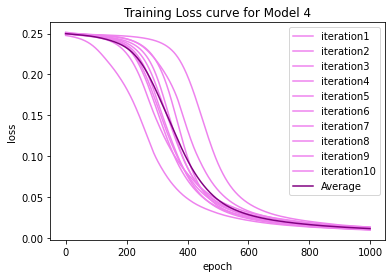

In [24]:
vals=model_loss_plots[3]
c=1
for loss in vals:
    epochs=range(len(loss))
    plt.plot(epochs, loss, 'violet',label="iteration" + str(c))
    c+=1


a = np.array(vals)

res = np.average(a, axis=0)
plt.plot(epochs, res, 'purple',label="Average")
    
plt.title("Training Loss curve for Model 4")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

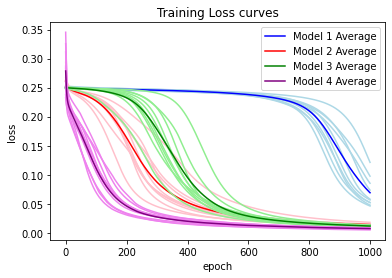

In [25]:
colors=[['lightblue','blue'],['pink','red'],['lightgreen','green'],['violet','purple']]
for i in range(1,5):
    vals=model_loss_plots[i]
    c=1
    for loss in vals:
        epochs=range(len(loss))
        plt.plot(epochs, loss, colors[i-1][0])
        c+=1


    a = np.array(vals)

    res = np.average(a, axis=0)
    plt.plot(epochs, res, colors[i-1][1],label="Model "+str(i)+" Average")

plt.title("Training Loss curves")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

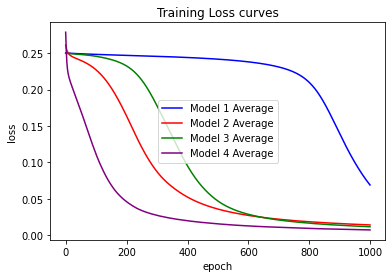

In [26]:
colors=[['lightblue','blue'],['pink','red'],['lightgreen','green'],['violet','purple']]
for i in range(1,5):
    vals=model_loss_plots[i]
    c=1
    a = np.array(vals)

    res = np.average(a, axis=0)
    plt.plot(epochs, res, colors[i-1][1],label="Model "+str(i)+" Average")

plt.title("Training Loss curves")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

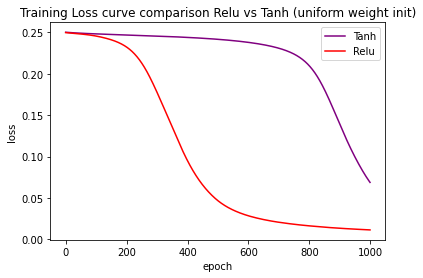

In [27]:
vals=model_loss_plots[1]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'purple',label="Tanh")

vals=model_loss_plots[3]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'red',label="Relu")

    
plt.title("Training Loss curve comparison Relu vs Tanh (uniform weight init)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

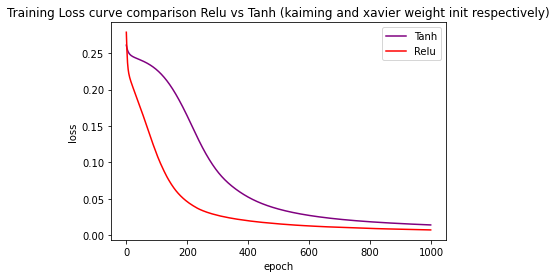

In [28]:
vals=model_loss_plots[2]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'purple',label="Tanh")

vals=model_loss_plots[4]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'red',label="Relu")

    
plt.title("Training Loss curve comparison Relu vs Tanh (kaiming and xavier weight init respectively)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

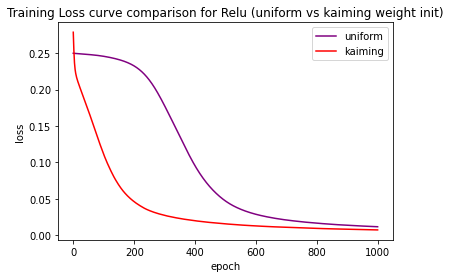

In [29]:
vals=model_loss_plots[3]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'purple',label="uniform")

vals=model_loss_plots[4]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'red',label="kaiming")

    
plt.title("Training Loss curve comparison for Relu (uniform vs kaiming weight init)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

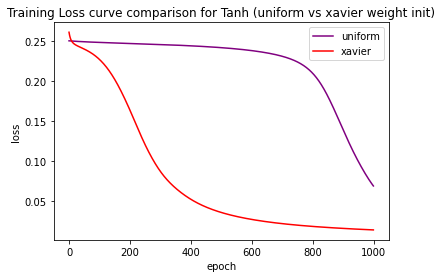

In [30]:
vals=model_loss_plots[1]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'purple',label="uniform")

vals=model_loss_plots[2]
a = np.array(vals)
res = np.average(a, axis=0)
plt.plot(epochs, res, 'red',label="xavier")

    
plt.title("Training Loss curve comparison for Tanh (uniform vs xavier weight init)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

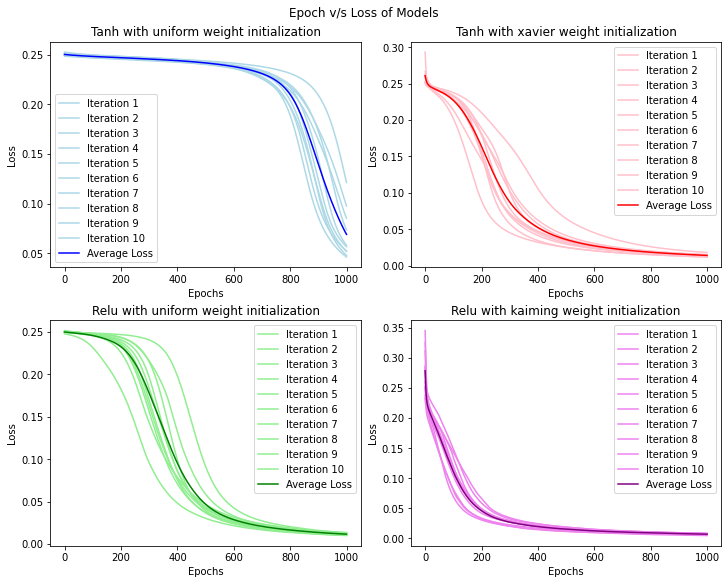

In [31]:
model_types_outputs=['Tanh with uniform weight initialization','Tanh with xavier weight initialization','Relu with uniform weight initialization','Relu with kaiming weight initialization']
colors=[['lightblue','blue'],['pink','red'],['lightgreen','green'],['violet','purple']]
import numpy as np

plt.rcParams["figure.figsize"] = (10,8)   
fig, ax = plt.subplots(nrows=2, ncols=2,constrained_layout=True)
for train_out, subax, ind in zip(model_types_outputs, ax.flat,range(1,5)):
    title_part1 = train_out
    # plotting losses
    subax.set_title(title_part1)
    subax.set_xlabel("Epochs")
    subax.set_ylabel("Loss")
    plt.suptitle("Epoch v/s Loss of Models")
    epoch_loss_list = model_loss_plots[ind]
    title_part1
    for i in range(10):
        subax.plot(epoch_loss_list[i], colors[ind-1][0],label="Iteration {}".format(i+1))

    average_loss = np.mean(model_loss_plots[ind], axis=0)
    subax.plot(average_loss,colors[ind-1][1], label="Average Loss")
    subax.legend()

      1     2     3      4
0  95.0  99.2  99.9   99.9
1  92.5  99.0  99.4   99.7
2  97.6  99.6  99.5   99.6
3  96.8  99.4  99.1   99.9
4  97.4  99.4  99.6   99.7
5  97.3  99.4  99.4   99.9
6  93.4  99.2  99.7   99.8
7  96.5  99.4  99.6  100.0
8  98.1  99.1  99.7   99.3
9  96.7  99.2  99.6   99.4


Text(0.5, 1.0, 'Comparison of Model Train Accuracies')

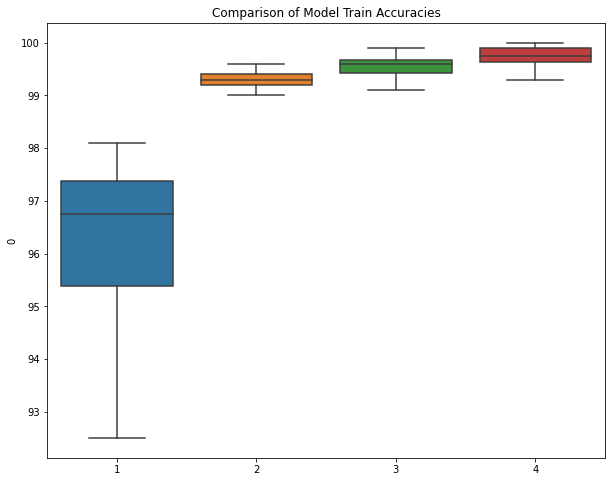

In [40]:
plt.rcParams["figure.figsize"] = (10,8)
# f, axes = plt.subplots(2, 2, sharey=True)

df = pd.DataFrame(model_accuracies_train_plots)
print(df)
unstacked = df.unstack().to_frame()
sns.boxplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0]).set_title('Comparison of Model Train Accuracies')

In [41]:
print(df.mean())

1    96.13
2    99.29
3    99.55
4    99.72
dtype: float64


In [42]:
print(df.std())

1    1.880928
2    0.179196
3    0.217307
4    0.229976
dtype: float64


      1     2     3     4
0  94.5  99.0  99.0  98.6
1  91.6  99.0  99.0  99.4
2  97.6  99.3  99.2  98.7
3  96.9  99.5  98.8  98.9
4  97.3  99.3  99.1  99.1
5  96.7  99.2  98.9  98.8
6  92.7  98.8  99.0  98.8
7  97.1  99.1  99.0  98.7
8  97.8  98.6  99.1  98.5
9  96.4  99.0  99.5  98.0


Text(0.5, 1.0, 'Comparison of Model Test Accuracies')

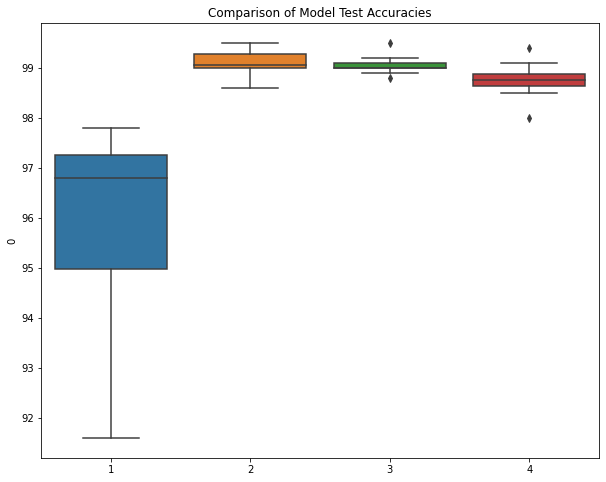

In [43]:
df = pd.DataFrame(model_accuracies_test_plots)
print(df)
unstacked = df.unstack().to_frame()
sns.boxplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0]).set_title('Comparison of Model Test Accuracies')

In [44]:
print(df.mean())

1    95.86
2    99.08
3    99.06
4    98.75
dtype: float64


In [45]:
print(df.std())

1    2.172147
2    0.261619
3    0.189737
4    0.368932
dtype: float64


     1    2    3    4
0  5.0  0.8  0.1  0.1
1  7.5  1.0  0.6  0.3
2  2.4  0.4  0.5  0.4
3  3.2  0.6  0.9  0.1
4  2.6  0.6  0.4  0.3
5  2.7  0.6  0.6  0.1
6  6.6  0.8  0.3  0.2
7  3.5  0.6  0.4  0.0
8  1.9  0.9  0.3  0.7
9  3.3  0.8  0.4  0.6


Text(0.5, 1.0, 'Comparison of Model Train Errors')

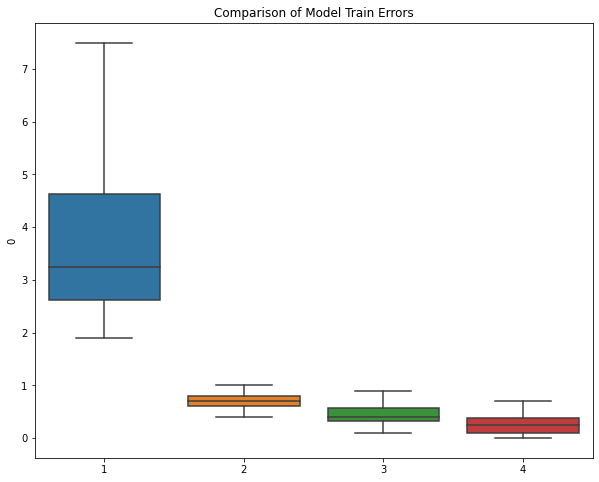

In [46]:
df = pd.DataFrame(model_error_train_plots)
print(df)
unstacked = df.unstack().to_frame()
sns.boxplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0]).set_title('Comparison of Model Train Errors')

In [47]:
print(df.mean())

1    3.87
2    0.71
3    0.45
4    0.28
dtype: float64


In [48]:
print(df.std())

1    1.880928
2    0.179196
3    0.217307
4    0.229976
dtype: float64


     1    2    3    4
0  5.5  1.0  1.0  1.4
1  8.4  1.0  1.0  0.6
2  2.4  0.7  0.8  1.3
3  3.1  0.5  1.2  1.1
4  2.7  0.7  0.9  0.9
5  3.3  0.8  1.1  1.2
6  7.3  1.2  1.0  1.2
7  2.9  0.9  1.0  1.3
8  2.2  1.4  0.9  1.5
9  3.6  1.0  0.5  2.0


Text(0.5, 1.0, 'Comparison of Model Test Errors')

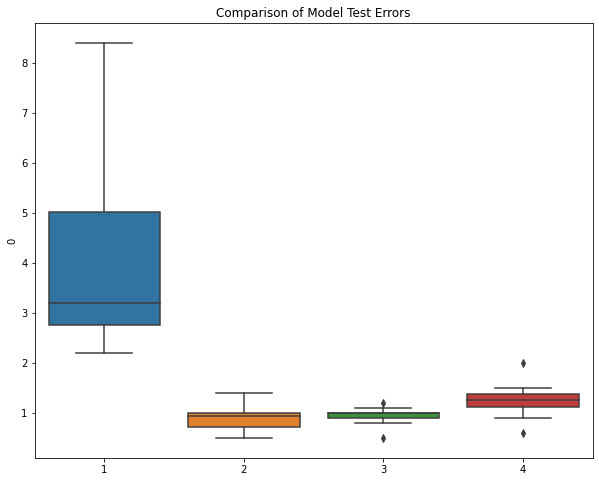

In [49]:
df = pd.DataFrame(model_error_test_plots)
print(df)
unstacked = df.unstack().to_frame()
sns.boxplot(
    x=unstacked.index.get_level_values(0),
    y=unstacked[0]).set_title('Comparison of Model Test Errors')

In [50]:
print(df.mean())

1    4.14
2    0.92
3    0.94
4    1.25
dtype: float64


In [51]:
print(df.std())

1    2.172147
2    0.261619
3    0.189737
4    0.368932
dtype: float64


# 5. Results
The results for the models are as follows:

| **Model Number** | **Activation** | **Loss**      | **Weight Initialisation** | **Training Accuracy** | **Testing Accuracy** | **Training Error** | **Testing Error** |
|:----------------:|:--------------:|:-------------:|:-------------------------:|:---------------------:|:--------------------:|:------------------:|:-----------------:|
| 1                | TanH           | MSE           | Uniform                   | 95.74%                | 93.98%               |2.07%               |2.52%              |
| 2                | TanH           | MSE           | Xavier                    | 99.52%                | 99.54%               |0.35%               |0.66%              |
| 3                | ReLU           | MSE           | Uniform                   | 99.72%                | 99.28%               |0.36%               |0.66%              |
| 4                | ReLU           | MSE           | kaiming                   | 99.75%                | 98.06%               |0.18%               |0.92%              |